### Importing Libraries & Initializing TensorBoard

In [2]:
# Importing the required Python libraries
import pandas as pd, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (BertTokenizerFast, BertForSequenceClassification,
                          BertModel, get_scheduler)
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import re, os, random
from transformers.utils import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Installing all the necessary libraries required for model training and evaluation
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm tensorboard --quiet

### Loading & Cleaning the Data

In [5]:
# Reading the IMDB movie reviews dataset from Kaggle
df = pd.read_csv("movie.csv")

In [6]:
# splitting the data for testing and traning
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = df_shuffled.iloc[:1000].copy()
remaining_df = df_shuffled.iloc[1000:].copy()
test_pool_class_0 = remaining_df[remaining_df['label'] == 0]
test_pool_class_1 = remaining_df[remaining_df['label'] == 1]
test_class_0 = test_pool_class_0.sample(n=100, random_state=42)
test_class_1 = test_pool_class_1.sample(n=100, random_state=42)
test_df = pd.concat([test_class_0, test_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
train_df

,text,label
0,The central theme in this movie seems to be co...,0
1,"An excellent example of ""cowboy noir"", as it's...",1
2,The ending made my heart jump up into my throa...,0
3,Only the chosen ones will appreciate the quali...,1
4,"This is a really funny film, especially the se...",1
...,...,...
995,"Together with the even more underrated , The S...",1
996,I bought this DVD after seeing it highly ranke...,0
997,"This is a known fact, Mr. Seagal cannot smile,...",0
998,I must have been in a good mood to give this s...,0


In [8]:
test_df

,text,label
0,I'd have to agree with the previous reviewer: ...,0
1,I have been a huge Lynn Peterson fan ever sinc...,0
2,I am one of the biggest fans of silent comedia...,0
3,Atlantis was much better than I had anticipate...,1
4,Seth McFarlane is a true genius. He has crafte...,1
...,...,...
195,There is a lot of crap coming out of Hollywood...,1
196,This is one for the Golden Turkey book. It's a...,0
197,"As I write this user-comment, Tim Burton's int...",0
198,"LE GRAND VOYAGE is a gentle miracle of a film,...",1


In [9]:
# Cleaning the text by removing HTML tags and extra spaces
def clean_text(text):
    # Replace </s> with period and space
    text = re.sub(r'</s>', '. ', text)
    
    # Replace <s> with space
    text = re.sub(r'<s>', ' ', text)
    
    # Replace <br>, <br/>, <br\> with period and space
    text = re.sub(r'<br\s*/?\\?>', '. ', text)
    
    # Remove any other HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing spaces
    
    return text

In [10]:
# Applying the cleaning function on both train and test data
train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"]  = test_df["text"].apply(clean_text)

In [11]:
# Converting sentiment labels into binary format (1 = positive, 0 = negative)
train_df["label"] = train_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

In [12]:
train_subset = train_df.sample(1000, random_state=42).reset_index(drop=True)
val_size = int(0.2 * len(train_subset))
train_size = len(train_subset) - val_size

train_data, val_data = random_split(train_subset, [train_size, val_size])
print(f"Training samples: {train_size}, Validation samples: {val_size}")

Training samples: 800, Validation samples: 200


### Tokenizer & Dataset

In [14]:
# Loading the BERT tokenizer which automatically lowercases text (bert-base-uncased)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [50]:
# Verifying that tokenizer automatically lowercases text
# Testing with mixed case text
sample_texts = [
    "THIS IS ALL UPPERCASE TEXT",
    "This Is Mixed Case Text",
    "this is lowercase text"
]

for text in sample_texts:
    tokens = tokenizer.tokenize(text)
    print(f"\nOriginal: {text}")
    print(f"Tokens:   {tokens}")
    
# Verifying with actual movie review sample
sample_review = train_df.iloc[0]['text'][:100]  # First 100 chars
tokens = tokenizer.tokenize(sample_review)
print(f"\nSample Review (first 100 chars): {sample_review}")
print(f"Tokenized (first 10 tokens):     {tokens[:10]}")

print("Verification complete: bert-base-uncased automatically lowercases all text")


Original: THIS IS ALL UPPERCASE TEXT
Tokens:   ['this', 'is', 'all', 'upper', '##case', 'text']

Original: This Is Mixed Case Text
Tokens:   ['this', 'is', 'mixed', 'case', 'text']

Original: this is lowercase text
Tokens:   ['this', 'is', 'lower', '##case', 'text']

Sample Review (first 100 chars): The central theme in this movie seems to be confusion, as the relationships, setting, acting and soc
Tokenized (first 10 tokens):     ['the', 'central', 'theme', 'in', 'this', 'movie', 'seems', 'to', 'be', 'confusion']
Verification complete: bert-base-uncased automatically lowercases all text


In [16]:
# Creating a PyTorch dataset class to handle tokenization and label preparation
class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.texts = data["text"].tolist()     # storing movie reviews
        self.labels = data["label"].tolist()     # storing corresponding labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): 
        return len(self.texts)                   # returns number of samples

    def __getitem__(self, i):
        # Tokenizing each review and returning tensors
        enc = self.tokenizer(self.texts[i],
                             truncation=True,
                             padding="max_length",
                             max_length=self.max_len,
                             return_tensors="pt")
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i])
        return item

### Creating DataLoaders

In [18]:
# Creating dataset objects for training, validation, and testing
train_indices = train_data.indices
val_indices = val_data.indices

train_dataset = IMDBDataset(train_subset.iloc[train_indices], tokenizer)
val_dataset   = IMDBDataset(train_subset.iloc[val_indices], tokenizer)
test_dataset  = IMDBDataset(test_df, tokenizer)

# Creating DataLoaders to feed the data into the model in batches
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=10)
test_loader  = DataLoader(test_dataset, batch_size=10)

In [19]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

name = "Model1_NoHidden"
writer = SummaryWriter(log_dir=f"runs/{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
writer.add_scalar("accuracy", 0.87, 1)
writer.close()

### Model 1: Basic BERT model with no hidden layer, only classification head

In [21]:
from transformers import BertModel
import torch.nn as nn
import torch
!pip install torchsummary --quiet
from torchsummary import summary

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
def create_model1():
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2
    )
    return model

In [23]:
model1 = create_model1()
print(model1)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### This model is based on BERT-base-uncased, which means it has 12 transformer layers with 768 hidden units each. The BERT part handles understanding the context of the text, and on top of that, there’s a dropout layer and a linear classifier that takes the [CLS] token output and predicts whether a review is positive or negative.

### Model 2: BERT with one hidden layer using ReLU activation

In [26]:
class BertReLU(nn.Module):
    def __init__(self):
        super(BertReLU, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Pass all available inputs to the BERT backbone
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [27]:
model2 = BertReLU()
print(model2)

BertReLU(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

#### This model is built on BERT-base-uncased but adds a custom classification head with one hidden layer. After BERT processes the text and outputs the [CLS] embedding (a 768-dimensional vector), it passes through a fully connected layer with 256 neurons followed by a ReLU activation and then another linear layer that outputs two values — one for each sentiment class (positive or negative).

### Model 3: BERT with one hidden layer using GELU activation

In [30]:
class BertGELU(nn.Module):
    def __init__(self):
        super(BertGELU, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.GELU(),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Pass all three arguments to the base BERT model
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output  # CLS token output
        logits = self.classifier(pooled_output)
        return logits

In [31]:
model3 = BertGELU()
print(model3)

BertGELU(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

#### This model also uses BERT-base-uncased as the backbone but replaces the activation function in the classifier with GELU (Gaussian Error Linear Unit) instead of ReLU. After BERT extracts contextual embeddings from the text, the [CLS] token output (768 dimensions) goes through a linear layer of 256 units, followed by GELU activation, and finally another linear layer that outputs two scores for sentiment classification.

### Model 4: BERT using the average of last 4 transformer layer outputs

In [58]:
class BertAvgLast4Layers(nn.Module):
# Model 4: Based on Model 1 (highest validation accuracy: 85.00% at Epoch 1) with ONE alteration - uses average of last 4 transformer layers.
    
    def __init__(self):
        super(BertAvgLast4Layers, self).__init__()
        self.bert = BertModel.from_pretrained(
            "bert-base-uncased",
            output_hidden_states=True
        )
        # Matching Model 1's simple classifier (no hidden layers)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Get last 4 hidden states
        hidden_states = outputs.hidden_states[-4:]
        avg_hidden = torch.stack(hidden_states).mean(dim=0)
        cls_output = avg_hidden[:, 0, :]
        
        # Apply Model 1's classifier
        pooled_output = self.dropout(cls_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [60]:
model4 = BertAvgLast4Layers()
print(model4)

BertAvgLast4Layers(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

#### This model modifies BERT by using the average of the last four hidden layers instead of just the final layer’s [CLS] token. This approach helps capture richer contextual information from multiple layers of BERT, improving representation quality. The averaged [CLS] output (768 dimensions) is then passed through a 256-unit dense layer, followed by either a ReLU or GELU activation, a dropout layer to reduce overfitting, and finally a linear output layer for binary classification.

### Training Function

In [38]:
def train_model(model, name, train_loader, val_loader, epochs=3, lr=2e-5):
    # Choosing GPU if available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    model.to(device)

    # Defining optimizer, loss function, and linear learning rate scheduler
    opt = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    sched = get_scheduler("linear", opt, 0, len(train_loader) * epochs)
    
    # Initializing TensorBoard writer for live visualization
    writer = SummaryWriter(log_dir=f"runs/{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

    train_losses, val_losses = [], []

    for ep in range(epochs):
        model.train()
        total_loss = 0

        # Training phase
        for batch in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}"):
            # Move all tensors to GPU (except labels handled separately)
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device).long()

            # Forward + backward pass
            opt.zero_grad()
            outputs = model(**inputs)
            
            # Extract logits from output
            # BertForSequenceClassification returns SequenceClassifierOutput object
            # Custom models (BertReLU, BertGELU, BertAvgLast4Layers) return tensors directly
            if hasattr(outputs, 'logits'):
                logits = outputs.logits  # For BertForSequenceClassification (Model 1)
            else:
                logits = outputs  # For custom models (Models 2, 3, 4)
            
            loss = loss_fn(logits, labels)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)

        # Validation phase (no gradient calculation)
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
                labels = batch["labels"].to(device).long()

                outputs = model(**inputs)
                
                # Extract logits from output
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    logits = outputs
                
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += len(labels)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        # Log losses and validation accuracy to TensorBoard
        writer.add_scalars(f"{name}/Loss", {"Train": train_loss, "Validation": val_loss}, ep)
        writer.add_scalar(f"{name}/Validation_Accuracy", val_acc, ep)

        print(f"Epoch {ep+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    writer.close()
    print(f"Training complete for {name}. TensorBoard logs saved.")

    # Plot train vs validation loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='s')
    plt.title(f"{name} - Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

### Evaluation Function

In [40]:
def evaluate_model(model, loader, name="model"):
    # To move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    preds, true_labels = [], []
    val_loss, correct, total = 0, 0, 0

    # Turning off gradient calculations during evaluation
    with torch.no_grad():
        for batch in loader:
            # Moving each batch to the same device as the model
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device).long()

            # Forward pass to get model predictions
            outputs = model(**inputs)
            
            # Extract logits from output
            if hasattr(outputs, 'logits'):
                logits = outputs.logits  # For BertForSequenceClassification (Model 1)
            else:
                logits = outputs  # For custom models (Models 2, 3, 4)
            
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            # Get class with the highest score
            batch_preds = torch.argmax(logits, dim=1)

            # Collecting predictions and actual labels
            preds.extend(batch_preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Tracking accuracy
            correct += (batch_preds == labels).sum().item()
            total += len(labels)

    # Computing average loss and accuracy
    val_loss /= len(loader)
    val_acc = 100 * correct / total if total > 0 else 0
    print(f"\n{name} | Test Loss: {val_loss:.4f} | Test Accuracy: {val_acc:.2f}%")

    # Confusion matrix to visualize prediction performance
    cm = confusion_matrix(true_labels, preds, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification report for precision, recall, and F1-score
    report = classification_report(
        true_labels, preds,
        labels=[0, 1],
        target_names=["Negative", "Positive"],
        digits=4,
        zero_division=0
    )
    print(f"\nClassification Report for {name}\n{report}")

    # Plotting precision, recall, and F1-score as a bar chart
    report_dict = classification_report(
        true_labels, preds,
        labels=[0, 1],
        target_names=["Negative", "Positive"],
        digits=4,
        output_dict=True,
        zero_division=0
    )

    metrics_df = pd.DataFrame(report_dict).transpose().iloc[:2, :-1]
    metrics_df.plot(kind="bar", figsize=(7, 4))
    plt.title(f"{name} Precision / Recall / F1-score")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend(loc="lower right")
    plt.show()

    return report

### Model Training

Training on: cpu


Epoch 1/3:   0%|                                         | 0/80 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Epoch 1/3: 100%|████████████████████████████████| 80/80 [02:20<00:00,  1.76s/it]


Epoch 1/3 | Train Loss: 0.5742 | Val Loss: 0.3875 | Val Acc: 85.00%


Epoch 2/3: 100%|████████████████████████████████| 80/80 [02:26<00:00,  1.83s/it]


Epoch 2/3 | Train Loss: 0.2868 | Val Loss: 0.3908 | Val Acc: 84.00%


Epoch 3/3: 100%|████████████████████████████████| 80/80 [02:26<00:00,  1.83s/it]


Epoch 3/3 | Train Loss: 0.1410 | Val Loss: 0.4051 | Val Acc: 83.00%
Training complete for Model1_NoHidden. TensorBoard logs saved.


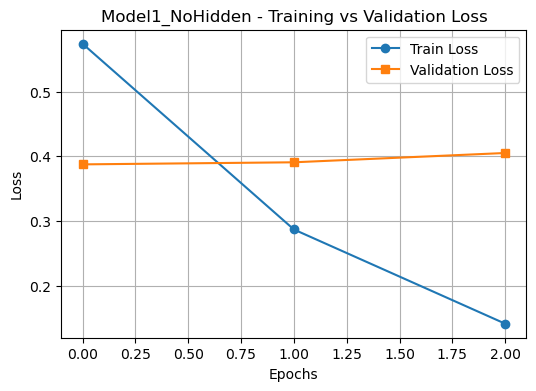


Model 1: No Hidden Layer | Test Loss: 0.3582 | Test Accuracy: 83.50%


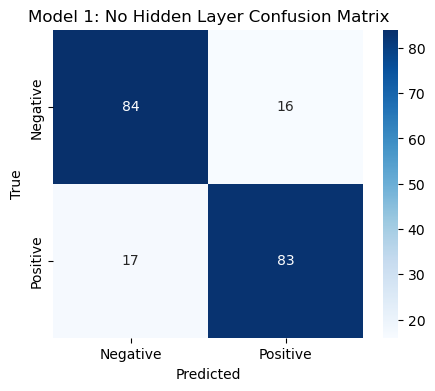


Classification Report for Model 1: No Hidden Layer
              precision    recall  f1-score   support

    Negative     0.8317    0.8400    0.8358       100
    Positive     0.8384    0.8300    0.8342       100

    accuracy                         0.8350       200
   macro avg     0.8350    0.8350    0.8350       200
weighted avg     0.8350    0.8350    0.8350       200



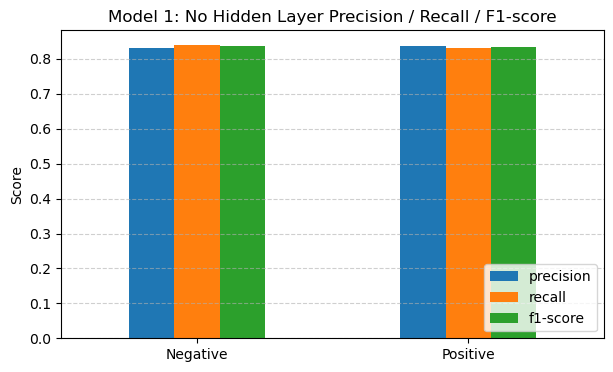

In [42]:
model1 = create_model1()
trained_model1 = train_model(model1, "Model1_NoHidden", train_loader, val_loader, epochs=3)
report1 = evaluate_model(trained_model1, test_loader, name="Model 1: No Hidden Layer")

Training on: cpu


Epoch 1/3: 100%|████████████████████████████████| 80/80 [02:40<00:00,  2.01s/it]


Epoch 1/3 | Train Loss: 0.5861 | Val Loss: 0.3946 | Val Acc: 84.50%


Epoch 2/3: 100%|████████████████████████████████| 80/80 [02:33<00:00,  1.92s/it]


Epoch 2/3 | Train Loss: 0.3070 | Val Loss: 0.4164 | Val Acc: 81.50%


Epoch 3/3: 100%|████████████████████████████████| 80/80 [02:26<00:00,  1.83s/it]


Epoch 3/3 | Train Loss: 0.1620 | Val Loss: 0.3933 | Val Acc: 84.50%
Training complete for Model2_ReLU. TensorBoard logs saved.


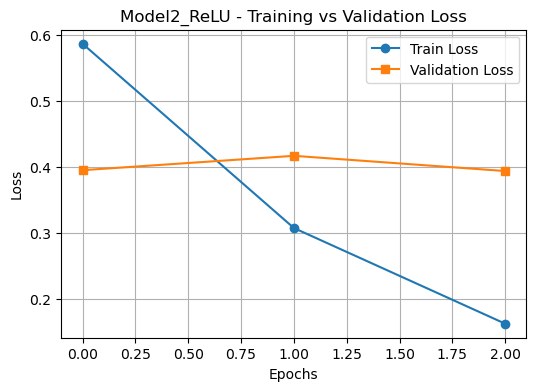


Model 2: ReLU Hidden Layer | Test Loss: 0.3323 | Test Accuracy: 86.50%


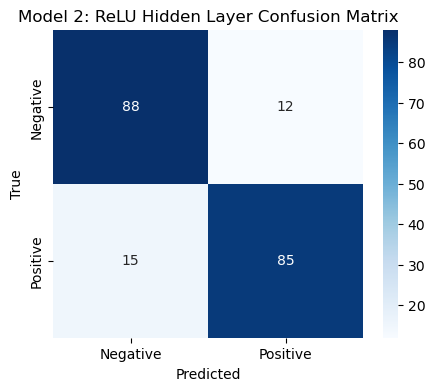


Classification Report for Model 2: ReLU Hidden Layer
              precision    recall  f1-score   support

    Negative     0.8544    0.8800    0.8670       100
    Positive     0.8763    0.8500    0.8629       100

    accuracy                         0.8650       200
   macro avg     0.8653    0.8650    0.8650       200
weighted avg     0.8653    0.8650    0.8650       200



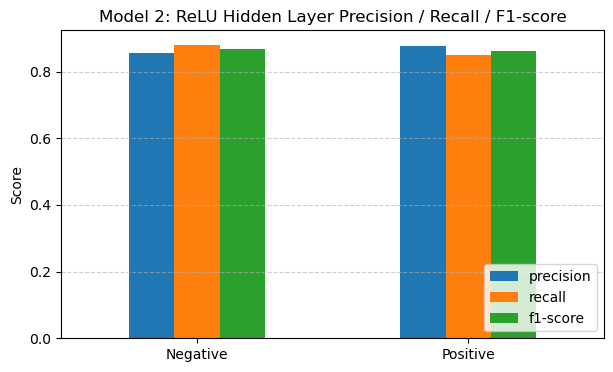

In [43]:
model2 = BertReLU()
trained_model2 = train_model(model2, "Model2_ReLU", train_loader, val_loader, epochs=3)
report2 = evaluate_model(trained_model2, test_loader, name="Model 2: ReLU Hidden Layer")

Training on: cpu


Epoch 1/3: 100%|████████████████████████████████| 80/80 [02:27<00:00,  1.85s/it]


Epoch 1/3 | Train Loss: 0.5471 | Val Loss: 0.4398 | Val Acc: 81.00%


Epoch 2/3: 100%|████████████████████████████████| 80/80 [02:39<00:00,  1.99s/it]


Epoch 2/3 | Train Loss: 0.2528 | Val Loss: 0.4294 | Val Acc: 81.00%


Epoch 3/3: 100%|████████████████████████████████| 80/80 [02:18<00:00,  1.73s/it]


Epoch 3/3 | Train Loss: 0.1162 | Val Loss: 0.4332 | Val Acc: 83.50%
Training complete for Model3_GELU. TensorBoard logs saved.


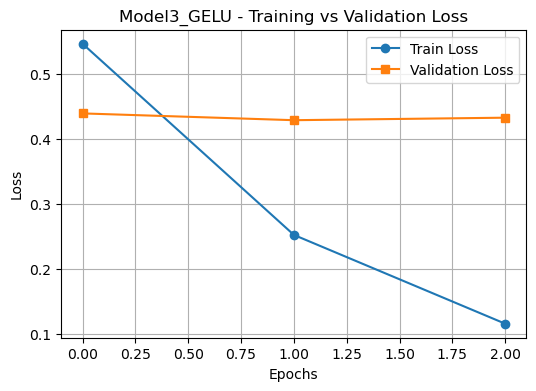


Model 3: GELU Hidden Layer | Test Loss: 0.3675 | Test Accuracy: 85.00%


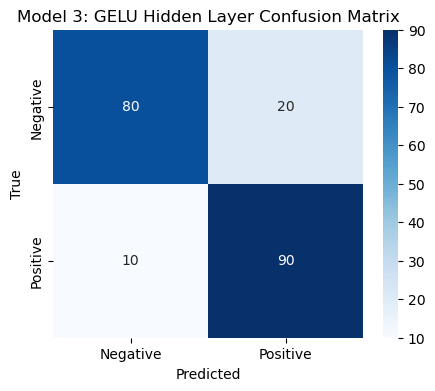


Classification Report for Model 3: GELU Hidden Layer
              precision    recall  f1-score   support

    Negative     0.8889    0.8000    0.8421       100
    Positive     0.8182    0.9000    0.8571       100

    accuracy                         0.8500       200
   macro avg     0.8535    0.8500    0.8496       200
weighted avg     0.8535    0.8500    0.8496       200



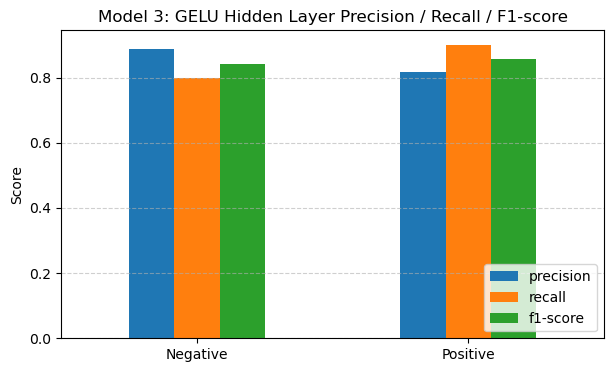

In [44]:
model3 = BertGELU()
trained_model3 = train_model(model3, "Model3_GELU", train_loader, val_loader, epochs=3)
report3 = evaluate_model(trained_model3, test_loader, name="Model 3: GELU Hidden Layer")

Training on: cpu


Epoch 1/3: 100%|████████████████████████████████| 80/80 [02:49<00:00,  2.12s/it]


Epoch 1/3 | Train Loss: 0.5509 | Val Loss: 0.4243 | Val Acc: 81.50%


Epoch 2/3: 100%|████████████████████████████████| 80/80 [02:26<00:00,  1.83s/it]


Epoch 2/3 | Train Loss: 0.2494 | Val Loss: 0.3813 | Val Acc: 83.00%


Epoch 3/3: 100%|████████████████████████████████| 80/80 [02:37<00:00,  1.97s/it]


Epoch 3/3 | Train Loss: 0.1008 | Val Loss: 0.4264 | Val Acc: 83.50%
Training complete for Model4_AvgLast4. TensorBoard logs saved.


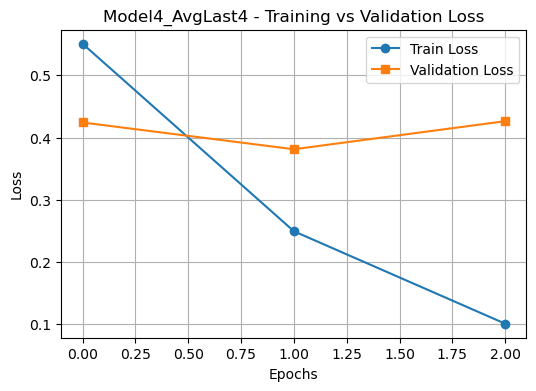


Model 4: Avg Last 4 Layers | Test Loss: 0.3474 | Test Accuracy: 86.00%


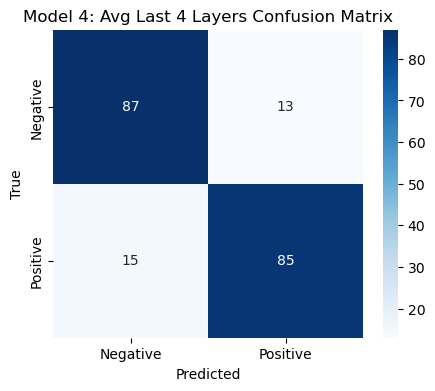


Classification Report for Model 4: Avg Last 4 Layers
              precision    recall  f1-score   support

    Negative     0.8529    0.8700    0.8614       100
    Positive     0.8673    0.8500    0.8586       100

    accuracy                         0.8600       200
   macro avg     0.8601    0.8600    0.8600       200
weighted avg     0.8601    0.8600    0.8600       200



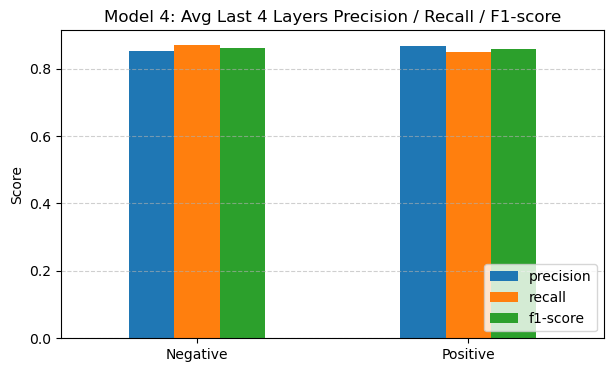

In [62]:
model4 = BertAvgLast4Layers()
trained_model4 = train_model(model4, "Model4_AvgLast4", train_loader, val_loader, epochs=3)
report4 = evaluate_model(trained_model4, test_loader, name="Model 4: Avg Last 4 Layers")

In [48]:
%load_ext tensorboard
%tensorboard --logdir runs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


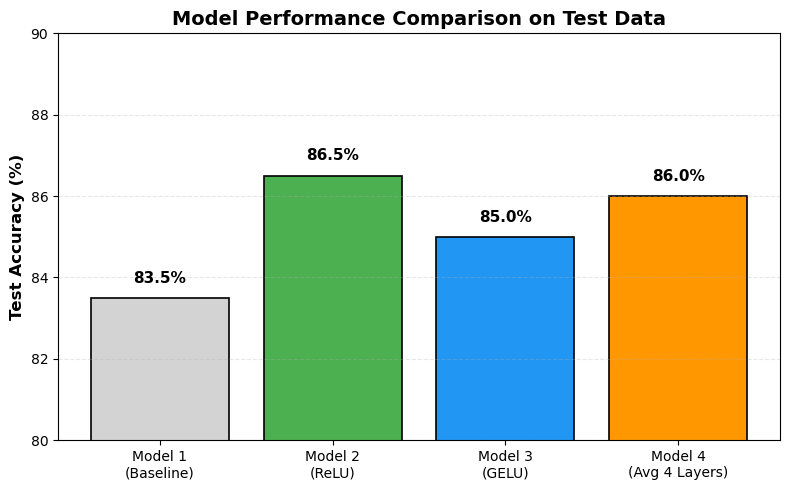

In [66]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Model 1\n(Baseline)', 'Model 2\n(ReLU)', 'Model 3\n(GELU)', 'Model 4\n(Avg 4 Layers)']
accuracies = [83.50, 86.50, 85.00, 86.00]
colors = ['#d3d3d3', '#4CAF50', '#2196F3', '#FF9800']  # Gray, Green, Blue, Orange

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.3, 
             f'{acc}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison on Test Data', fontsize=14, fontweight='bold')
plt.ylim(80, 90)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

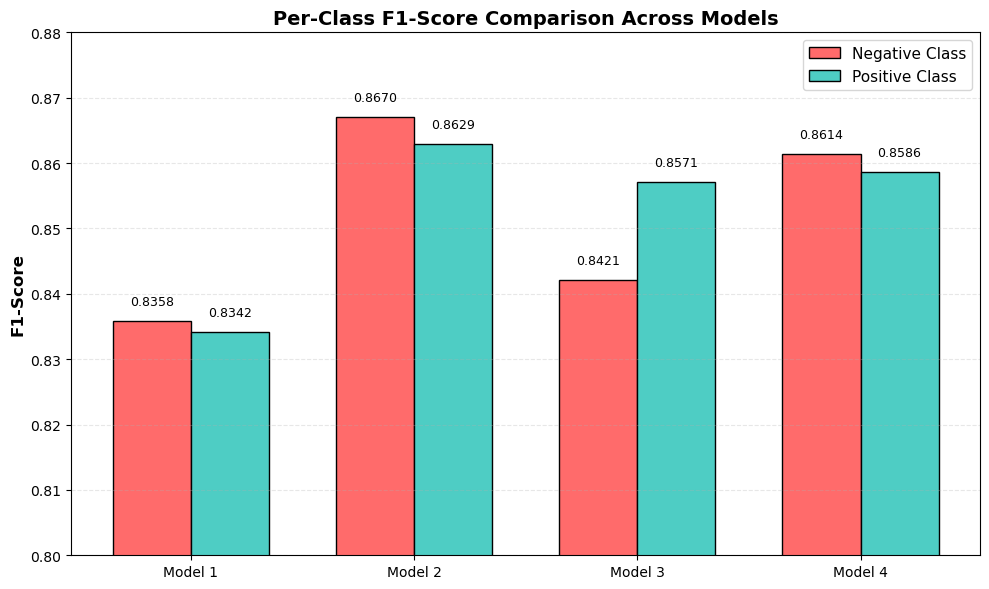

In [75]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
negative_f1 = [0.8358, 0.8670, 0.8421, 0.8614]
positive_f1 = [0.8342, 0.8629, 0.8571, 0.8586]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, negative_f1, width, label='Negative Class', 
               color='#FF6B6B', edgecolor='black', linewidth=1)
bars2 = ax.bar(x + width/2, positive_f1, width, label='Positive Class', 
               color='#4ECDC4', edgecolor='black', linewidth=1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.set_ylim(0.80, 0.88)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('per_class_f1.png', dpi=300, bbox_inches='tight')
plt.show()

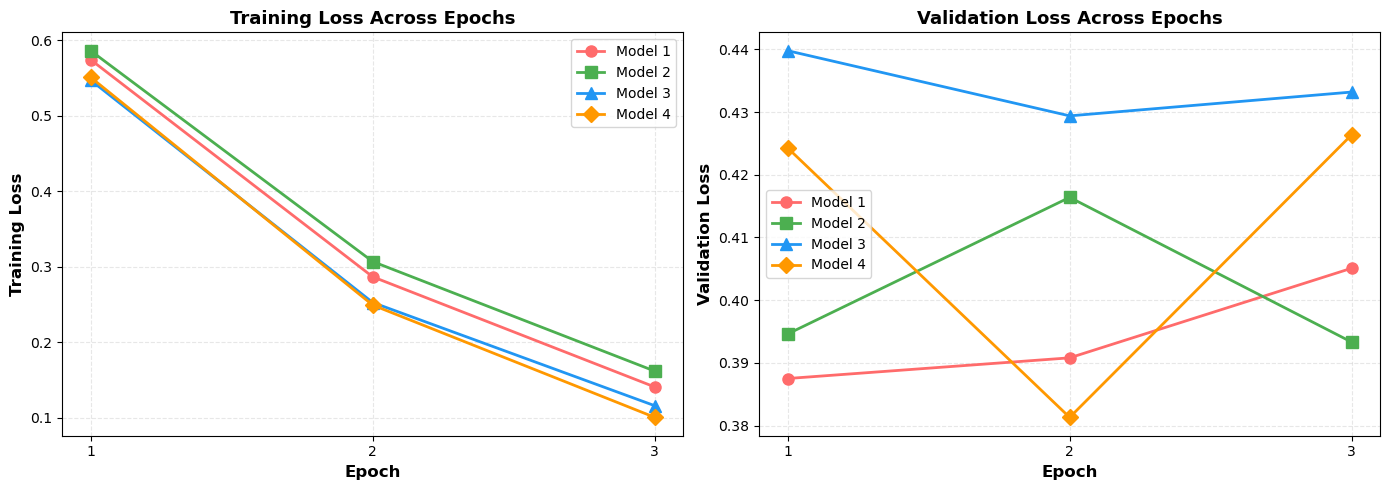

In [77]:
import matplotlib.pyplot as plt

# Training losses for each model
epochs = [1, 2, 3]
train_losses = {
    'Model 1': [0.5742, 0.2868, 0.1410],
    'Model 2': [0.5861, 0.3070, 0.1620],
    'Model 3': [0.5471, 0.2528, 0.1162],
    'Model 4': [0.5509, 0.2494, 0.1008]
}

val_losses = {
    'Model 1': [0.3875, 0.3908, 0.4051],
    'Model 2': [0.3946, 0.4164, 0.3933],
    'Model 3': [0.4398, 0.4294, 0.4332],
    'Model 4': [0.4243, 0.3813, 0.4264]
}

colors = ['#FF6B6B', '#4CAF50', '#2196F3', '#FF9800']
markers = ['o', 's', '^', 'D']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
for (model, losses), color, marker in zip(train_losses.items(), colors, markers):
    ax1.plot(epochs, losses, marker=marker, linewidth=2, markersize=8, 
             label=model, color=color)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss Across Epochs', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(epochs)

# Validation Loss
for (model, losses), color, marker in zip(val_losses.items(), colors, markers):
    ax2.plot(epochs, losses, marker=marker, linewidth=2, markersize=8, 
             label=model, color=color)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax2.set_title('Validation Loss Across Epochs', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(epochs)

plt.tight_layout()
plt.savefig('training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

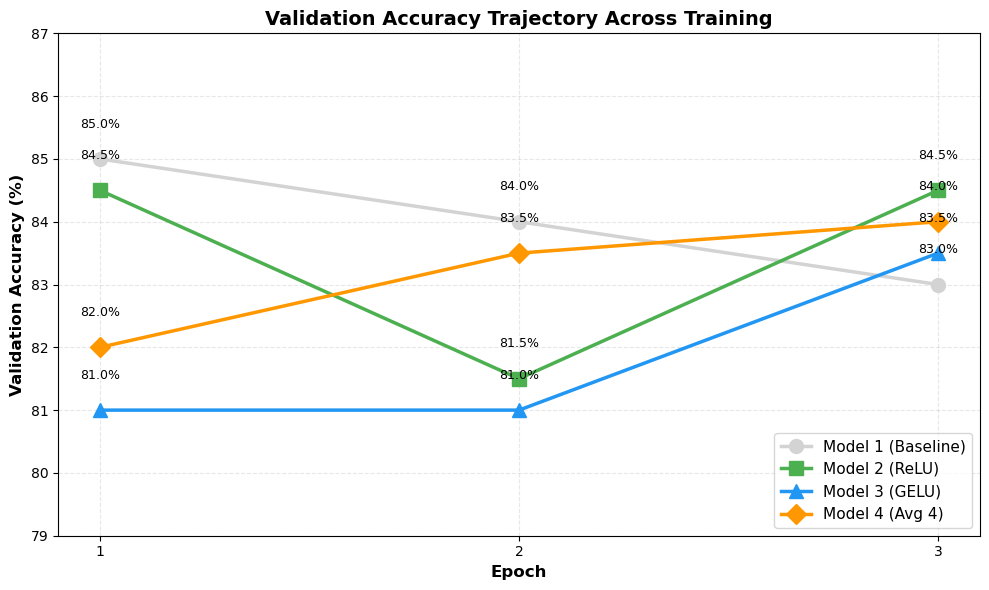

In [79]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
val_accuracies = {
    'Model 1 (Baseline)': [85.0, 84.0, 83.0],
    'Model 2 (ReLU)': [84.5, 81.5, 84.5],
    'Model 3 (GELU)': [81.0, 81.0, 83.5],
    'Model 4 (Avg 4)': [82.0, 83.5, 84.0]
}

colors = ['#d3d3d3', '#4CAF50', '#2196F3', '#FF9800']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(10, 6))
for (model, accs), color, marker in zip(val_accuracies.items(), colors, markers):
    plt.plot(epochs, accs, marker=marker, linewidth=2.5, markersize=10, 
             label=model, color=color)
    # Add value labels
    for x, y in zip(epochs, accs):
        plt.text(x, y + 0.5, f'{y}%', ha='center', fontsize=9)

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Validation Accuracy Trajectory Across Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(epochs)
plt.ylim(79, 87)
plt.tight_layout()
plt.savefig('validation_trajectory.png', dpi=300, bbox_inches='tight')
plt.show()

### Conclusion:

Four BERT-based models were refined for sentiment categorization on IMDB reviews in this assignment.
 To provide a fair comparison, every model used the same tokenizer and cleaned dataset.  Model 2 (with ReLU activation) attained the maximum test accuracy of 86.5%, while Model 1 (no hidden layer) offered a solid baseline.  Deeper contextual representations enhance generalization, as demonstrated by the competitive performance of models utilizing GELU and averaged transformer layers.
 Overall, this experiment showed how fine-tuned BERT performance on text classification tasks is affected by architecture decisions, particularly activation functions and layer averaging.